In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore') # Ignores any eventual warnings in the notebook

In [2]:
# Read CSV file
data = pd.read_csv('PhageAcr_ML_dataset_mmseqs.csv')
data.set_index('ID', inplace=True)                              # Set the "ID" column as the index

In [3]:
# Check information regarding dataset
print(data.isna().sum())        # Check if any of the columns have missing values
print(data.info())              # Check column types
data.describe(include='all')    # Check statistics

Protein_Acr                              0
length                                   0
charge                                   0
chargedensity                            0
formulaC                                 0
formulaH                                 0
formulaN                                 0
formulaO                                 0
formulaS                                 0
tot                                      0
hydrogen                                 0
single                                   0
double                                   0
MW_modlamp                               0
Gravy                                    0
Aromacity                                0
IsoelectricPoint                         0
Instability_index                        0
SecStruct_helix                          0
SecStruct_turn                           0
SecStruct_sheet                          0
Molar_extinction_coefficient_reduced     0
Molar_extinction_coefficient_oxidized    0
aliphatic_i

,Protein_Acr,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,...,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,0.500000,243.374774,-6.534474,-0.000279,1184.306058,1843.261302,315.565099,378.321881,7.746835,4311.480108,...,5.710305,35.579229,0.332045,0.281237,0.357984,32717.662749,32803.896926,82.267622,1.653862,0.369035
std,0.500113,180.906677,8.483597,0.000400,853.483733,1337.533393,234.133173,278.097589,5.218354,3129.040880,...,1.479793,11.533871,0.046964,0.041405,0.041516,24635.786620,24675.652686,11.195202,0.492524,0.038009
min,0.000000,47.000000,-56.820000,-0.001984,235.000000,360.000000,58.000000,71.000000,0.000000,845.000000,...,4.050028,-2.384375,0.168919,0.147368,0.206612,0.000000,0.000000,37.142857,-0.135890,0.227848
25%,0.000000,104.000000,-10.336250,-0.000426,529.000000,830.000000,137.750000,166.000000,4.000000,1918.750000,...,4.768672,28.083602,0.301800,0.255556,0.330573,14440.000000,14440.000000,75.123132,1.318215,0.344359
50%,0.500000,155.000000,-5.065000,-0.000232,767.000000,1176.500000,200.000000,246.000000,6.000000,2760.500000,...,5.206986,35.095411,0.330836,0.283333,0.355004,24980.000000,24980.000000,82.254030,1.628457,0.367877
75%,1.000000,392.000000,-1.266500,-0.000070,1881.250000,2956.000000,504.250000,600.250000,10.000000,6852.750000,...,6.090037,42.711416,0.360825,0.307692,0.382740,44920.000000,45107.500000,88.961858,1.984334,0.392884
max,1.000000,1528.000000,26.079000,0.001504,6997.000000,11033.000000,1885.000000,2326.000000,34.000000,25717.000000,...,11.800051,83.999286,0.506494,0.475207,0.571429,216580.000000,216830.000000,135.324675,4.079714,0.537975


In [4]:
X = data.drop('Protein_Acr', axis=1) 
y = data['Protein_Acr'].values

# Split the dataset into training+validation (80%) and test sets (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # random_state will allow for the reproductibility of the split

# Split the training+validation set into training (70%) and validation sets (10% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Checking the shape of the resulting sets
print(f'Training Set \t Shape of X_train: {X_train.shape} \n\t\t Shape of y_train: {y_train.shape} \n')
print(f'Validation Set \t Shape of X_val: {X_val.shape} \n\t\t Shape of y_val: {y_val.shape} \n')
print(f'Test Set \t Shape of X_test: {X_test.shape} \n\t\t Shape of y_test: {y_test.shape}')

# Selecting scoring metrics (there are more available)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1'] 

Training Set 	 Shape of X_train: (1547, 25) 
		 Shape of y_train: (1547,) 

Validation Set 	 Shape of X_val: (222, 25) 
		 Shape of y_val: (222,) 

Test Set 	 Shape of X_test: (443, 25) 
		 Shape of y_test: (443,)


# Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(random_state=42)
print(estimator)

selector = SelectKBest(f_classif)
selector.fit(X, y)
X_new = selector.transform(X)

print(X.shape)
print(X_new.shape)

# Check what were the selected features:
selected_features = X.iloc[:, selector.get_support(indices=True)].columns.tolist()
print('Selected Features: %s' % selected_features)

DecisionTreeClassifier(random_state=42)
(2212, 25)
(2212, 10)
Selected Features: ['length', 'formulaC', 'formulaH', 'formulaN', 'formulaO', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp']


In [6]:
## Pipeline
# Define the pipeline
pipeline = Pipeline([('selector', selector), 
                     ('scaler', StandardScaler()), 
                     ('dt', estimator)])

# Define the parameters to test
params_to_test = {'selector__k': [30, 25, 20, 15, 10, 5],
                  'dt__max_depth': [None, 5, 10, 20],  
                  'dt__min_samples_split': [2, 5, 10]} 

grid_search = GridSearchCV(pipeline, params_to_test, cv=3)  # Hyperparameter Optimization
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

gs_results = pd.DataFrame.from_dict(data=grid_search.cv_results_)
gs_results

Best parameters: {'dt__max_depth': None, 'dt__min_samples_split': 2, 'selector__k': 20}
Best score: 0.8733047339504779


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__max_depth,param_dt__min_samples_split,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041720,0.002719,0.003979,0.000955,None,2,30,"{'dt__max_depth': None, 'dt__min_samples_split...",0.831395,0.868217,0.864078,0.854563,0.016469,37
1,0.039650,0.002109,0.003387,0.000072,None,2,25,"{'dt__max_depth': None, 'dt__min_samples_split...",0.831395,0.868217,0.864078,0.854563,0.016469,37
2,0.033232,0.003557,0.003441,0.000159,None,2,20,"{'dt__max_depth': None, 'dt__min_samples_split...",0.870155,0.874031,0.875728,0.873305,0.002332,1
3,0.026550,0.001560,0.003119,0.000659,None,2,15,"{'dt__max_depth': None, 'dt__min_samples_split...",0.839147,0.846899,0.862136,0.849394,0.009549,51
4,0.019992,0.001161,0.003190,0.000588,None,2,10,"{'dt__max_depth': None, 'dt__min_samples_split...",0.835271,0.852713,0.858252,0.848746,0.009792,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.043277,0.001472,0.003779,0.000183,20,10,25,"{'dt__max_depth': 20, 'dt__min_samples_split':...",0.835271,0.866279,0.864078,0.855209,0.014127,31
68,0.034039,0.003076,0.003271,0.000399,20,10,20,"{'dt__max_depth': 20, 'dt__min_samples_split':...",0.862403,0.872093,0.862136,0.865544,0.004632,14
69,0.025518,0.001910,0.004591,0.000703,20,10,15,"{'dt__max_depth': 20, 'dt__min_samples_split':...",0.837209,0.854651,0.867961,0.853274,0.012592,41
70,0.020177,0.001220,0.003001,0.000005,20,10,10,"{'dt__max_depth': 20, 'dt__min_samples_split':...",0.841085,0.817829,0.846602,0.835172,0.012468,69


In [7]:
best_params_dt = grid_search.best_params_       # Define best parameters
best_pipeline_dt = grid_search.best_estimator_
best_pipeline_dt

Pipeline(steps=[('selector', SelectKBest(k=20)), ('scaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [8]:
# Divide train dataset into 5 folds (cv=5). For each iteration, 1 fold will be used as validation set, remaining 4 folds will be used to train the model
cv_scores = cross_validate(best_pipeline_dt, X_train, y_train, scoring=scoring_metrics, cv=5, return_train_score=False)

for key, value in cv_scores.items():
    if key != "fit_time" and key != "score_time":
        print("Metric: %s" % key)
        print("Results of each fold: %s" % value) # resultados de cada fold
        print("Mean of all folds: %s" % np.mean(value))
        print("Standard Deviation: %s" % np.std(value), "\n")
    
# Recommended to save model evaluation results in files!

Metric: test_accuracy
Results of each fold: [0.86129032 0.86129032 0.88349515 0.87378641 0.87055016]
Mean of all folds: 0.8700824720743293
Standard Deviation: 0.008347951493445393 

Metric: test_precision
Results of each fold: [0.84810127 0.85714286 0.88741722 0.90714286 0.87333333]
Mean of all folds: 0.8746275063969756
Standard Deviation: 0.021127489455044585 

Metric: test_recall
Results of each fold: [0.87581699 0.8627451  0.87581699 0.83006536 0.86184211]
Mean of all folds: 0.8612573099415204
Standard Deviation: 0.016729985303745906 

Metric: test_f1
Results of each fold: [0.86173633 0.85993485 0.88157895 0.8668942  0.86754967]
Mean of all folds: 0.8675388004040304
Standard Deviation: 0.007603025432384248 



In [9]:
# Train the model on the complete dataset:
model_dt = best_pipeline_dt.fit(X_train, y_train)

y_test_pred_dt = model_dt.predict(X_test)

matrix = confusion_matrix(y_test, y_test_pred_dt)
matrix

array([[196,  21],
       [ 30, 196]], dtype=int64)

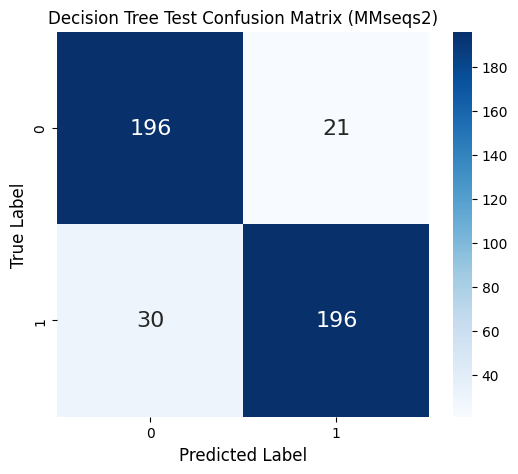

In [10]:
## Confusion Matrix
matrix = confusion_matrix(y_test, y_test_pred_dt)

# Plot the confusion matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Decision Tree Test Confusion Matrix (MMseqs2)')
plt.show()

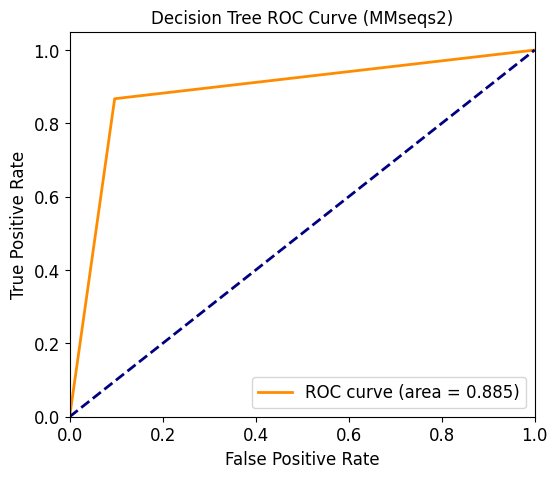

In [11]:
## ROC Curve and AUC
# Calculate predicted probabilities for the test set
y_test_pred_prob = model_dt.predict_proba(X_test)[:, 1]                         # Calculate the predicted probabilities for the test set
test_fpr_dt, test_tpr_dt, thresholds = roc_curve(y_test, y_test_pred_prob)      # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the test set
test_roc_auc_dt = auc(test_fpr_dt, test_tpr_dt)                                 # Calculate the area under the ROC curve (AUC) for the test set

# Plot the ROC curve for the test set
plt.figure(figsize=(6, 5))
plt.plot(test_fpr_dt, test_tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Decision Tree ROC Curve (MMseqs2)')
plt.legend(loc='lower right', fontsize=12)                  # Increase font size of legend
plt.tick_params(axis='both', which='major', labelsize=12)   # Increase font size of axis numbers
plt.show()

In [12]:
## Metrics
accuracy = accuracy_score(y_test, y_test_pred_dt)
precision = precision_score(y_test, y_test_pred_dt)
recall = recall_score(y_test, y_test_pred_dt)
f1 = f1_score(y_test, y_test_pred_dt)

print("Decision Tree Test Results:")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

# Create a DataFrame
metrics_dt = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Decision Tree': [accuracy, precision, recall, f1]
}).round(2)

Decision Tree Test Results:
Test Accuracy: 0.88
Test Precision: 0.90
Test Recall: 0.87
Test F1-Score: 0.88


# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=42)
print(estimator)

selector = SelectKBest(f_classif)
selector.fit(X, y)
X_new = selector.transform(X)

print(X.shape)
print(X_new.shape)

# Check what were the selected features:
selected_features = X.iloc[:, selector.get_support(indices=True)].columns.tolist()
print('Selected Features: %s' % selected_features)

RandomForestClassifier(random_state=42)
(2212, 25)
(2212, 10)
Selected Features: ['length', 'formulaC', 'formulaH', 'formulaN', 'formulaO', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp']


In [14]:
## Pipeline
# Define the pipeline
pipeline = Pipeline([('selector', selector), 
                     ('scaler', StandardScaler()), 
                     ('rf', estimator)])

# Define the parameters to test
params_to_test = {'selector__k': [30, 25, 20, 15, 10, 5],
                  'rf__n_estimators': [50, 100, 150],  
                  'rf__max_depth': [None, 5, 10, 20],   
                  'rf__min_samples_split': [2, 5, 10]} 

grid_search = GridSearchCV(pipeline, params_to_test, cv=3)  # Hyperparameter Optimization
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

gs_results = pd.DataFrame.from_dict(data=grid_search.cv_results_)
gs_results

Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'selector__k': 30}
Best score: 0.9043438448608917


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.358044,0.019972,0.012420,0.003868,None,2,50,30,"{'rf__max_depth': None, 'rf__min_samples_split...",0.881783,0.906977,0.924272,0.904344,0.017446,1
1,0.387174,0.026035,0.010956,0.000727,None,2,50,25,"{'rf__max_depth': None, 'rf__min_samples_split...",0.881783,0.906977,0.924272,0.904344,0.017446,1
2,0.311453,0.020108,0.010666,0.001064,None,2,50,20,"{'rf__max_depth': None, 'rf__min_samples_split...",0.874031,0.891473,0.918447,0.894650,0.018271,51
3,0.243050,0.010056,0.010070,0.001484,None,2,50,15,"{'rf__max_depth': None, 'rf__min_samples_split...",0.864341,0.889535,0.912621,0.888832,0.019717,99
4,0.257222,0.011466,0.010269,0.000208,None,2,50,10,"{'rf__max_depth': None, 'rf__min_samples_split...",0.852713,0.872093,0.897087,0.873965,0.018164,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.367194,0.004495,0.008552,0.000416,20,10,150,25,"{'rf__max_depth': 20, 'rf__min_samples_split':...",0.883721,0.895349,0.912621,0.897230,0.011873,36
212,0.315237,0.001175,0.007999,0.000002,20,10,150,20,"{'rf__max_depth': 20, 'rf__min_samples_split':...",0.881783,0.883721,0.924272,0.896592,0.019589,38
213,0.255374,0.002439,0.008393,0.000557,20,10,150,15,"{'rf__max_depth': 20, 'rf__min_samples_split':...",0.874031,0.877907,0.914563,0.888834,0.018262,97
214,0.254493,0.003365,0.008000,0.000001,20,10,150,10,"{'rf__max_depth': 20, 'rf__min_samples_split':...",0.862403,0.862403,0.889320,0.871376,0.012689,171


In [15]:
best_params_rf = grid_search.best_params_  # Define best parameters
best_pipeline_rf = grid_search.best_estimator_
best_pipeline_rf

Pipeline(steps=[('selector', SelectKBest(k=30)), ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [16]:
# Divide train dataset into 5 folds (cv=5). For each iteration, 1 fold will be used as validation set, remaining 4 folds will be used to train the model
cv_scores = cross_validate(best_pipeline_rf, X_train, y_train, scoring=scoring_metrics, cv=5, return_train_score=False)

for key, value in cv_scores.items():
    if key != "fit_time" and key != "score_time":
        print("Métrica: %s" % key)
        print("Resultados de cada fold: %s" % value) # resultados de cada fold
        print("Média de todas as folds: %s" % np.mean(value))
        print("Desvio padrão: %s" % np.std(value), "\n")
    
# Recommended to save model evaluation results in files!

Métrica: test_accuracy
Resultados de cada fold: [0.90645161 0.87096774 0.9223301  0.89967638 0.93527508]
Média de todas as folds: 0.9069401816473537
Desvio padrão: 0.0218482677236998 

Métrica: test_precision
Resultados de cada fold: [0.86046512 0.85093168 0.89570552 0.86746988 0.90243902]
Média de todas as folds: 0.8754022437356825
Desvio padrão: 0.02013980838640883 

Métrica: test_recall
Resultados de cada fold: [0.96732026 0.89542484 0.95424837 0.94117647 0.97368421]
Média de todas as folds: 0.9463708290333678
Desvio padrão: 0.027818808817282003 

Métrica: test_f1
Resultados de cada fold: [0.91076923 0.87261146 0.92405063 0.90282132 0.93670886]
Média de todas as folds: 0.909392301204538
Desvio padrão: 0.021720795575231978 



In [17]:
# Train the model on the complete dataset:
model_rf = best_pipeline_rf.fit(X_train, y_train)

y_test_pred_rf = model_rf.predict(X_test)

matrix = confusion_matrix(y_test, y_test_pred_rf)
matrix

array([[196,  21],
       [ 12, 214]], dtype=int64)

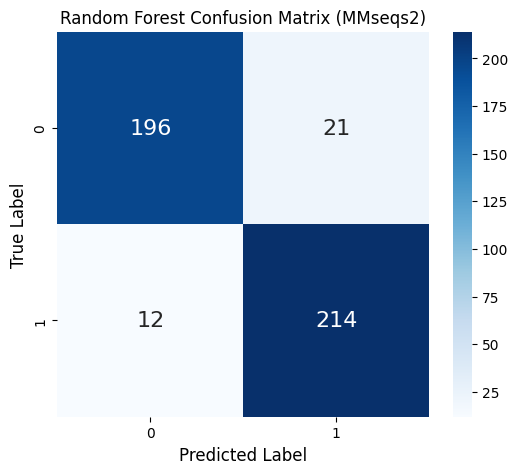

In [18]:
## Confusion Matrix
matrix = confusion_matrix(y_test, y_test_pred_rf)

# Plot the confusion matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Random Forest Confusion Matrix (MMseqs2)')
plt.show()

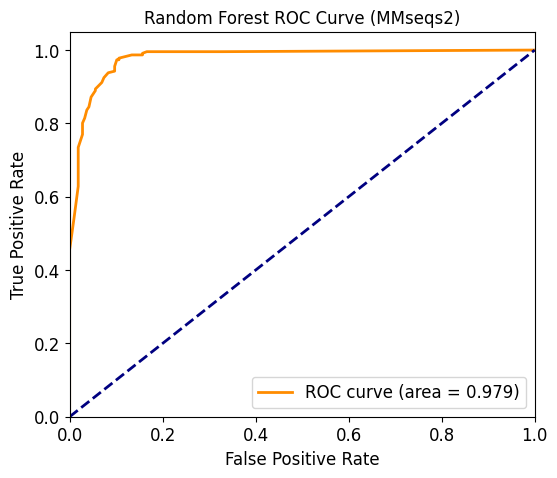

In [19]:
## ROC Curve and AUC
# Calculate predicted probabilities for the test set
y_test_pred_prob = model_rf.predict_proba(X_test)[:, 1]                         # Calculate the predicted probabilities for the test set
test_fpr_rf, test_tpr_rf, thresholds = roc_curve(y_test, y_test_pred_prob)      # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the test set
test_roc_auc_rf = auc(test_fpr_rf, test_tpr_rf)                                 # Calculate the area under the ROC curve (AUC) for the test set

# Plot the ROC curve for the test set
plt.figure(figsize=(6, 5))
plt.plot(test_fpr_rf, test_tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest ROC Curve (MMseqs2)')
plt.legend(loc='lower right', fontsize=12)                  # Increase font size of legend
plt.tick_params(axis='both', which='major', labelsize=12)   # Increase font size of axis numbers
plt.show()

In [20]:
# Metrics
accuracy = accuracy_score(y_test, y_test_pred_rf)
precision = precision_score(y_test, y_test_pred_rf)
recall = recall_score(y_test, y_test_pred_rf)
f1 = f1_score(y_test, y_test_pred_rf)

print("Decision Tree Test Results:")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

# Create a DataFrame
metrics_rf = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Random Forest': [accuracy, precision, recall, f1]
}).round(2)

Decision Tree Test Results:
Test Accuracy: 0.93
Test Precision: 0.91
Test Recall: 0.95
Test F1-Score: 0.93


# Support Vector Machine (SVM)

In [21]:
from sklearn.svm import SVC

estimator = SVC(probability=True, random_state=42)
print(estimator)

selector = SelectKBest(f_classif)
selector.fit(X, y)
X_new = selector.transform(X)

print(X.shape)
print(X_new.shape)

# Check what were the selected features:
selected_features = X.iloc[:, selector.get_support(indices=True)].columns.tolist()
print('Atributos seleccionados: %s' % selected_features)

SVC(probability=True, random_state=42)
(2212, 25)
(2212, 10)
Atributos seleccionados: ['length', 'formulaC', 'formulaH', 'formulaN', 'formulaO', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp']


In [22]:
## Pipeline
# Define the pipeline
pipeline = Pipeline([('selector', selector), 
                     ('scaler', StandardScaler()), 
                     ('svm', estimator)])

# Define the parameters to test
params_to_test = {'selector__k': [30, 25, 20, 15, 10, 5],
                  'svm__C': [0.1, 1, 10],        
                  'svm__kernel': ['rbf']}

grid_search = GridSearchCV(pipeline, params_to_test, cv=3)  # Hyperparameter Optimization
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

gs_results = pd.DataFrame.from_dict(data=grid_search.cv_results_)
gs_results

Best parameters: {'selector__k': 20, 'svm__C': 10, 'svm__kernel': 'rbf'}
Best score: 0.9127417776774291


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,param_svm__C,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104439,0.003993,0.015792,0.000292,30,0.1,rbf,"{'selector__k': 30, 'svm__C': 0.1, 'svm__kerne...",0.860465,0.862403,0.881553,0.868141,0.009517,10
1,0.076218,0.000968,0.011728,0.000523,30,1,rbf,"{'selector__k': 30, 'svm__C': 1, 'svm__kernel'...",0.897287,0.910853,0.912621,0.906920,0.006850,4
2,0.080989,0.002266,0.010004,0.000002,30,10,rbf,"{'selector__k': 30, 'svm__C': 10, 'svm__kernel...",0.897287,0.914729,0.918447,0.910154,0.009224,2
3,0.097599,0.003567,0.015299,0.000423,25,0.1,rbf,"{'selector__k': 25, 'svm__C': 0.1, 'svm__kerne...",0.860465,0.862403,0.881553,0.868141,0.009517,10
4,0.080528,0.002623,0.011720,0.000670,25,1,rbf,"{'selector__k': 25, 'svm__C': 1, 'svm__kernel'...",0.897287,0.910853,0.912621,0.906920,0.006850,4
5,0.080280,0.001755,0.010002,0.000002,25,10,rbf,"{'selector__k': 25, 'svm__C': 10, 'svm__kernel...",0.897287,0.914729,0.918447,0.910154,0.009224,2
6,0.081417,0.002372,0.014199,0.000595,20,0.1,rbf,"{'selector__k': 20, 'svm__C': 0.1, 'svm__kerne...",0.860465,0.870155,0.885437,0.872019,0.010280,9
7,0.065623,0.001298,0.010906,0.000139,20,1,rbf,"{'selector__k': 20, 'svm__C': 1, 'svm__kernel'...",0.883721,0.901163,0.902913,0.895932,0.008664,6
8,0.070766,0.001030,0.009334,0.000473,20,10,rbf,"{'selector__k': 20, 'svm__C': 10, 'svm__kernel...",0.895349,0.918605,0.924272,0.912742,0.012514,1
9,0.068307,0.002158,0.013186,0.000263,15,0.1,rbf,"{'selector__k': 15, 'svm__C': 0.1, 'svm__kerne...",0.854651,0.868217,0.881553,0.868141,0.010983,10


In [23]:
best_params_svm = grid_search.best_params_      # Define best parameters
best_pipeline_svm = grid_search.best_estimator_
best_pipeline_svm

Pipeline(steps=[('selector', SelectKBest(k=20)), ('scaler', StandardScaler()),
                ('svm', SVC(C=10, probability=True, random_state=42))])

In [24]:
# Divide train dataset into 5 folds (cv=5). For each iteration, 1 fold will be used as validation set, remaining 4 folds will be used to train the model
cv_scores = cross_validate(best_pipeline_svm, X_train, y_train, scoring=scoring_metrics, cv=5, return_train_score=False)

for key, value in cv_scores.items():
    if key != "fit_time" and key != "score_time":
        print("Metric: %s" % key)
        print("Results of each fold: %s" % value)            # Results of each fold
        print("Mean of all folds: %s" % np.mean(value))
        print("Standard Deviation: %s" % np.std(value), "\n")
    
# Recommended to save model evaluation results in files!

Metric: test_accuracy
Results of each fold: [0.90967742 0.89032258 0.93527508 0.91262136 0.93203883]
Mean of all folds: 0.9159870550161813
Standard Deviation: 0.01636760359314946 

Metric: test_precision
Results of each fold: [0.86127168 0.86060606 0.9030303  0.89375    0.91194969]
Mean of all folds: 0.8861215450943064
Standard Deviation: 0.0213529772421779 

Metric: test_recall
Results of each fold: [0.97385621 0.92810458 0.97385621 0.93464052 0.95394737]
Mean of all folds: 0.9528809769521842
Standard Deviation: 0.01911879793715213 

Metric: test_f1
Results of each fold: [0.91411043 0.89308176 0.93710692 0.91373802 0.93247588]
Mean of all folds: 0.9181026024213675
Standard Deviation: 0.015676637312845795 



In [25]:
# Train the model on the complete dataset:
model_svm = best_pipeline_svm.fit(X_train, y_train)

y_test_pred_svm = model_svm.predict(X_test)

matrix = confusion_matrix(y_test, y_test_pred_svm)
matrix

array([[196,  21],
       [ 14, 212]], dtype=int64)

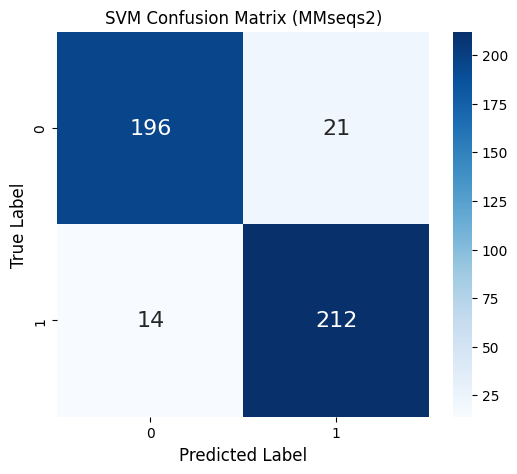

In [26]:
## Confusion Matrix
matrix = confusion_matrix(y_test, y_test_pred_svm)

# Plot the confusion matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('SVM Confusion Matrix (MMseqs2)')
plt.show()

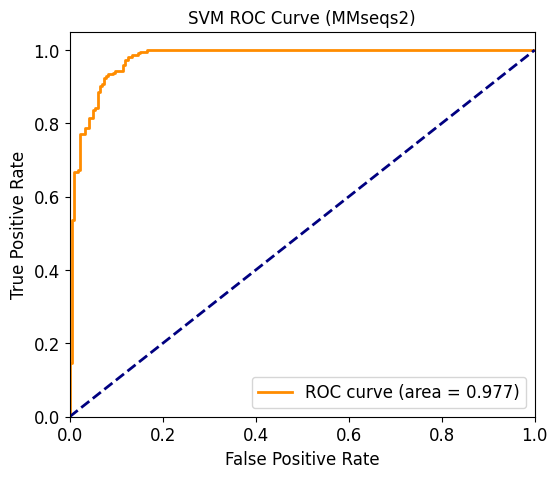

In [27]:
## ROC Curve and AUC

# Calculate predicted probabilities for the test set
y_test_pred_prob = model_svm.predict_proba(X_test)[:, 1]                        # Calculate the predicted probabilities for the test set
test_fpr_svm, test_tpr_svm, thresholds = roc_curve(y_test, y_test_pred_prob)    # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the test set
test_roc_auc_svm = auc(test_fpr_svm, test_tpr_svm)                              # Calculate the area under the ROC curve (AUC) for the test set

# Plot the ROC curve for the test set
plt.figure(figsize=(6, 5))
plt.plot(test_fpr_svm, test_tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc_svm:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('SVM ROC Curve (MMseqs2)')
plt.legend(loc='lower right', fontsize=12)                  # Increase font size of legend
plt.tick_params(axis='both', which='major', labelsize=12)   # Increase font size of axis numbers
plt.show()

In [28]:
## Metrics
accuracy = accuracy_score(y_test, y_test_pred_svm)
precision = precision_score(y_test, y_test_pred_svm)
recall = recall_score(y_test, y_test_pred_svm)
f1 = f1_score(y_test, y_test_pred_svm)

print("SVM Test Results:")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

# Create a DataFrame
metrics_svm = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'SVM': [accuracy, precision, recall, f1]
}).round(2)

SVM Test Results:
Test Accuracy: 0.92
Test Precision: 0.91
Test Recall: 0.94
Test F1-Score: 0.92


# eXtreme Gradiant Boosting (XGBoost)

In [29]:
from xgboost import XGBClassifier

estimator = XGBClassifier(random_state=42)
print(estimator)

selector = SelectKBest(f_classif)
selector.fit(X, y)
X_new = selector.transform(X)

print(X.shape)
print(X_new.shape)

# Check what were the selected features:
selected_features = X.iloc[:, selector.get_support(indices=True)].columns.tolist()
print('Selected Features: %s' % selected_features)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
(2212, 25)
(2212, 10)
Selected Features: ['length', 'formulaC', 'formulaH', 'formulaN', 'formulaO', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp']


In [30]:
## Pipeline
# Define the pipeline
pipeline = Pipeline([('selector', selector), 
                     ('scaler', StandardScaler()), 
                     ('xgb', estimator)])

# Define the parameters to test
params_to_test = {'selector__k': [30, 25, 20, 15, 10, 5],
                  'xgb__n_estimators': [50, 100, 150],  
                  'xgb__max_depth': [3, 5, 7],          
                  'xgb__learning_rate': [0.01, 0.1, 0.3]} 

grid_search = GridSearchCV(pipeline, params_to_test, cv=3)  # Hyperparameter Optimization
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

gs_results = pd.DataFrame.from_dict(data=grid_search.cv_results_)
gs_results

Best parameters: {'selector__k': 20, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
Best score: 0.9056333258071799


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040215,0.017274,0.002337,4.754770e-04,30,0.01,3,50,"{'selector__k': 30, 'xgb__learning_rate': 0.01...",0.864341,0.868217,0.856311,0.862956,0.004958,148
1,0.045333,0.001247,0.002668,4.694599e-04,30,0.01,3,100,"{'selector__k': 30, 'xgb__learning_rate': 0.01...",0.862403,0.872093,0.877670,0.870722,0.006308,121
2,0.062666,0.000941,0.002334,4.725517e-04,30,0.01,3,150,"{'selector__k': 30, 'xgb__learning_rate': 0.01...",0.862403,0.874031,0.887379,0.874604,0.010204,104
3,0.044332,0.000943,0.002335,4.718203e-04,30,0.01,5,50,"{'selector__k': 30, 'xgb__learning_rate': 0.01...",0.875969,0.887597,0.873786,0.879117,0.006062,88
4,0.079132,0.002342,0.003018,2.749256e-05,30,0.01,5,100,"{'selector__k': 30, 'xgb__learning_rate': 0.01...",0.877907,0.893411,0.873786,0.881701,0.008449,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.037000,0.000818,0.003002,9.733398e-07,5,0.3,5,100,"{'selector__k': 5, 'xgb__learning_rate': 0.3, ...",0.858527,0.850775,0.879612,0.862971,0.012185,147
158,0.053332,0.000944,0.002699,4.948956e-04,5,0.3,5,150,"{'selector__k': 5, 'xgb__learning_rate': 0.3, ...",0.854651,0.850775,0.879612,0.861679,0.012778,150
159,0.026045,0.000870,0.003000,2.144295e-06,5,0.3,7,50,"{'selector__k': 5, 'xgb__learning_rate': 0.3, ...",0.856589,0.852713,0.883495,0.864266,0.013689,145
160,0.044823,0.001156,0.002684,4.854509e-04,5,0.3,7,100,"{'selector__k': 5, 'xgb__learning_rate': 0.3, ...",0.860465,0.854651,0.885437,0.866851,0.013355,134


In [31]:
best_params_xgb = grid_search.best_params_      # Define best parameters
best_pipeline_xgb = grid_search.best_estimator_
best_pipeline_xgb

Pipeline(steps=[('selector', SelectKBest(k=20)), ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [32]:
# Divide train dataset into 5 folds (cv=5). For each iteration, 1 fold will be used as validation set, remaining 4 folds will be used to train the model
cv_scores = cross_validate(best_pipeline_xgb, X_train, y_train, scoring=scoring_metrics, cv=5, return_train_score=False)

for key, value in cv_scores.items():
    if key != "fit_time" and key != "score_time":
        print("Metric: %s" % key)
        print("Results of each fold: %s" % value)            # Results of each fold
        print("Mean of all folds: %s" % np.mean(value))
        print("Standard Deviation: %s" % np.std(value), "\n")

# Recommended to save model evaluation results in files!

Metric: test_accuracy
Results of each fold: [0.90967742 0.87096774 0.9223301  0.91585761 0.94174757]
Mean of all folds: 0.9121160872742458
Standard Deviation: 0.02321845521738932 

Metric: test_precision
Results of each fold: [0.86982249 0.85093168 0.91082803 0.9044586  0.92948718]
Mean of all folds: 0.8931055931833471
Standard Deviation: 0.028591388511114067 

Metric: test_recall
Results of each fold: [0.96078431 0.89542484 0.93464052 0.92810458 0.95394737]
Mean of all folds: 0.934580323357413
Standard Deviation: 0.022964418683995475 

Metric: test_f1
Results of each fold: [0.91304348 0.87261146 0.92258065 0.91612903 0.94155844]
Mean of all folds: 0.9131846124413638
Standard Deviation: 0.02257533801490408 



In [33]:
# Train the model on the complete dataset:
model_xgb = best_pipeline_xgb.fit(X_train, y_train)

y_test_pred_xgb = model_xgb.predict(X_test)

matrix = confusion_matrix(y_test, y_test_pred_xgb)
matrix

array([[199,  18],
       [ 14, 212]], dtype=int64)

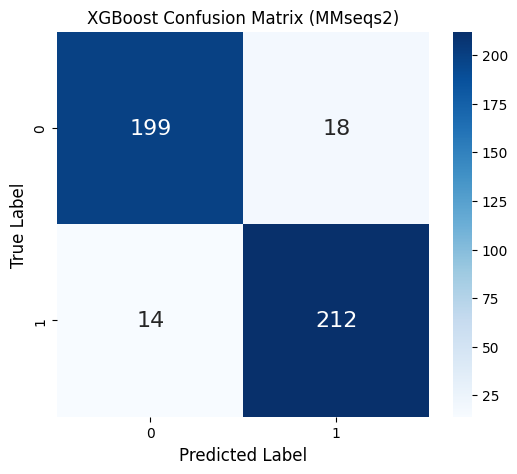

In [34]:
## Confusion Matrix
matrix = confusion_matrix(y_test, y_test_pred_xgb)

# Plot the confusion matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('XGBoost Confusion Matrix (MMseqs2)')
plt.show()

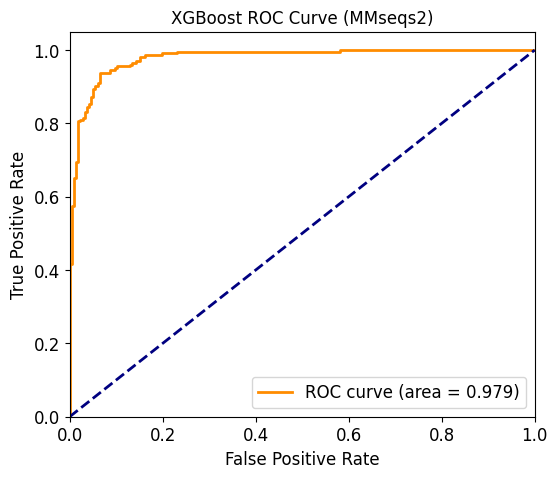

In [35]:
## ROC Curve and AUC
# Calculate predicted probabilities for the test set
y_test_pred_prob = model_xgb.predict_proba(X_test)[:, 1]                        # Calculate the predicted probabilities for the test set
test_fpr_xgb, test_tpr_xgb, thresholds = roc_curve(y_test, y_test_pred_prob)    # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for the test set
test_roc_auc_xgb = auc(test_fpr_xgb, test_tpr_xgb)                              # Calculate the area under the ROC curve (AUC) for the test set

# Plot the ROC curve for the test set
plt.figure(figsize=(6, 5))
plt.plot(test_fpr_xgb, test_tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('XGBoost ROC Curve (MMseqs2)')
plt.legend(loc='lower right', fontsize=12)                  # Increase font size of legend
plt.tick_params(axis='both', which='major', labelsize=12)   # Increase font size of axis numbers
plt.show()

In [36]:
## Metrics
accuracy = accuracy_score(y_test, y_test_pred_xgb)
precision = precision_score(y_test, y_test_pred_xgb)
recall = recall_score(y_test, y_test_pred_xgb)
f1 = f1_score(y_test, y_test_pred_xgb)

print("XGBoost Test Results:")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

# Create a DataFrame
metrics_xgb = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'XGBoost': [accuracy, precision, recall, f1]
}).round(2)

XGBoost Test Results:
Test Accuracy: 0.93
Test Precision: 0.92
Test Recall: 0.94
Test F1-Score: 0.93


# Combined Plots

### Combined Metrics dataframe

In [37]:
# Rename the columns of each DataFrame
metrics_dt.columns = ['Metric', 'Decision Tree']
metrics_rf.columns = ['Metric', 'Random Forest']
metrics_svm.columns = ['Metric', 'SVM']
metrics_xgb.columns = ['Metric', 'XGBoost']

# Concatenate all DataFrames into a single DataFrame
combined_metrics = pd.concat([metrics_dt.set_index('Metric'), 
                              metrics_rf.set_index('Metric'), 
                              metrics_svm.set_index('Metric'), 
                              metrics_xgb.set_index('Metric')], axis=1)

combined_metrics

,Decision Tree,Random Forest,SVM,XGBoost
Metric,,,,
Accuracy,0.88,0.93,0.92,0.93
Precision,0.90,0.91,0.91,0.92
Recall,0.87,0.95,0.94,0.94
F1 Score,0.88,0.93,0.92,0.93


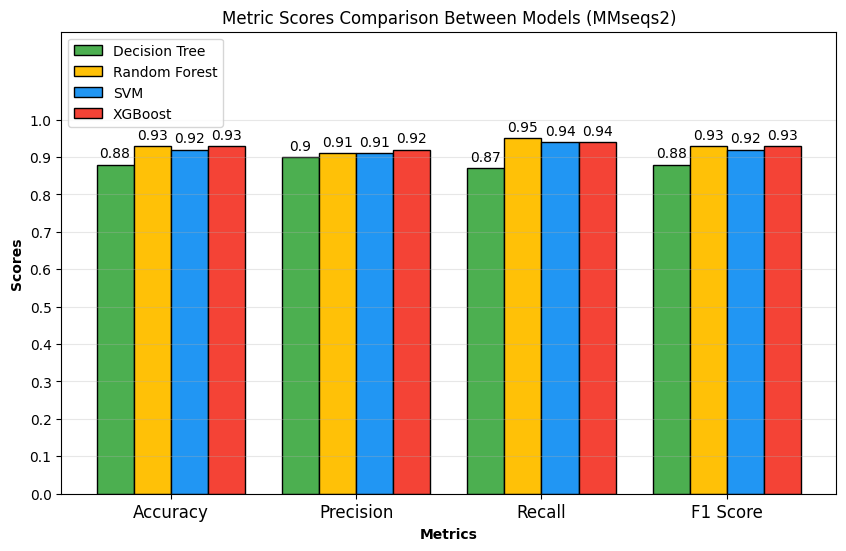

In [38]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Define the list of models from the columns
models = combined_metrics.columns.tolist()
num_models = len(models)

# Set the positions of the bars on the x-axis
r = [np.arange(len(combined_metrics.index))]    # Start positions for the first group
for i in range(1, num_models):
    r.append([x + 0.2 for x in r[i - 1]])       # Positions for subsequent groups

colors = ['#4CAF50', '#FFC107', '#2196F3', '#F44336']

# Plot each model's metrics
for i, model in enumerate(models):
    bars = plt.bar(r[i], combined_metrics[model], color=colors[i], width=0.2, edgecolor='black', label=model)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, round(yval, 2), va='bottom', ha='center')

plt.title('Metric Scores Comparison Between Models (MMseqs2)')
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + 0.2 * (num_models - 1) / 2 for r in range(len(combined_metrics.index))], combined_metrics.index, fontsize=12)
plt.ylim(top=combined_metrics.values.max() * 1.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='upper left')
plt.show()

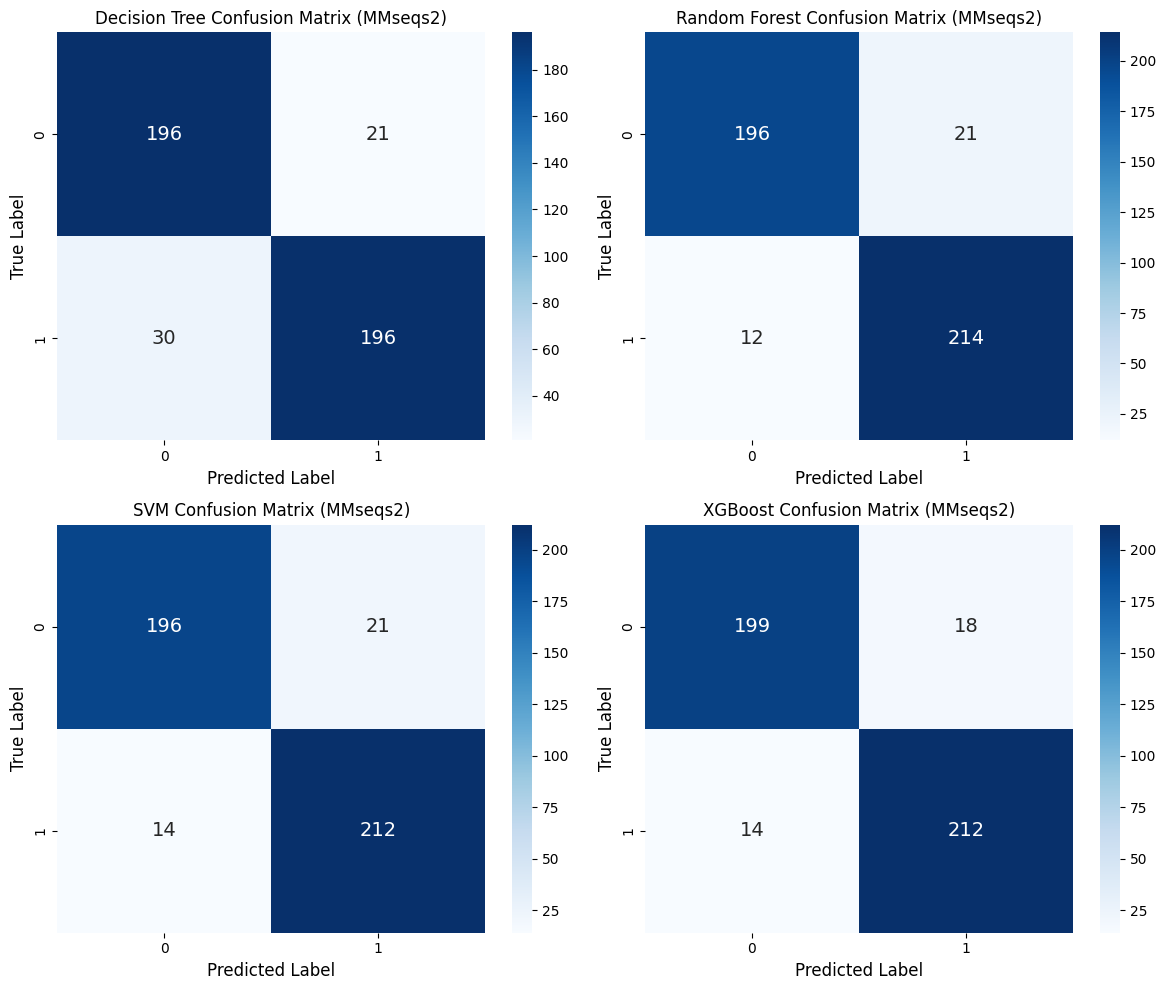

In [39]:
# Define the confusion matrices for all four models
confusion_matrices = {
    'Decision Tree': confusion_matrix(y_test, y_test_pred_dt),
    'Random Forest': confusion_matrix(y_test, y_test_pred_rf),
    'SVM': confusion_matrix(y_test, y_test_pred_svm),
    'XGBoost': confusion_matrix(y_test, y_test_pred_xgb)
}

# Plot the confusion matrices in a grid-like pattern
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (model, matrix) in zip(axes.flatten(), confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(f'{model} Confusion Matrix (MMseqs2)', fontsize=12)

plt.tight_layout()
plt.show()

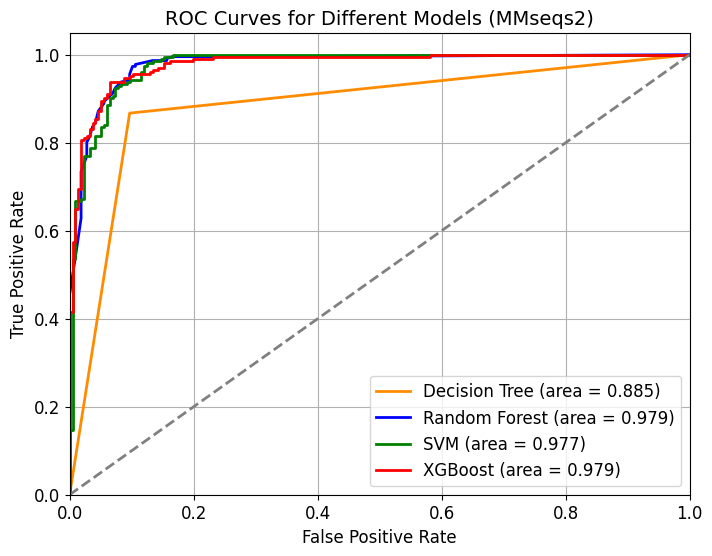

In [40]:
# Plot combined ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(test_fpr_dt, test_tpr_dt, color='darkorange', lw=2, label=f'Decision Tree (area = {test_roc_auc_dt:.3f})') # Plot ROC curve for Decision Tree
plt.plot(test_fpr_rf, test_tpr_rf, color='blue', lw=2, label=f'Random Forest (area = {test_roc_auc_rf:.3f})')       # Plot ROC curve for Random Forest
plt.plot(test_fpr_svm, test_tpr_svm, color='green', lw=2, label=f'SVM (area = {test_roc_auc_svm:.3f})')             # Plot ROC curve for SVM
plt.plot(test_fpr_xgb, test_tpr_xgb, color='red', lw=2, label=f'XGBoost (area = {test_roc_auc_xgb:.3f})')           # Plot ROC curve for XGBoost

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Different Models (MMseqs2)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()